In [23]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import datetime

# Load and preprocess the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# EfficientNet-specific preprocessing (normalizes pixels to [-1, 1])
x_train = tf.keras.applications.efficientnet.preprocess_input(x_train)
x_test = tf.keras.applications.efficientnet.preprocess_input(x_test)

# Convert class vectors to one-hot encoded labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Load EfficientNetB0 with pre-trained weights (include_top=False)
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(32, 32, 3)  # Despite resolution mismatch, we proceed
)

# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Build the model with critical layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Required for dimensionality reduction
    layers.Dense(256, activation='relu'),  # Restored for model capacity
    layers.Dropout(0.5),  # Restored to prevent overfitting
    layers.Dense(10, activation='softmax')
])

# Compile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir)

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=20,  # Reduced epochs for Colab efficiency
    # batch_size=64,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, reduce_lr, tensorboard_callback]
)

# Evaluate
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"\nTest accuracy: {test_acc:.4f}")

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 170s 64ms/step - accuracy: 0.2968 - loss: 2.1198 - val_accuracy: 0.6292 - val_loss: 1.0513 - learning_rate: 1.0000e-04
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - accuracy: 0.6044 - loss: 1.1502 - val_accuracy: 0.7221 - val_loss: 0.8024 - learning_rate: 1.0000e-04
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.6878 - loss: 0.9143 - val_accuracy: 0.7589 - val_loss: 0.7004 - learning_rate: 1.0000e-04
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - accuracy: 0.7352 - loss: 0.7784 - val_accuracy: 0.7821 - val_loss: 0.6372 - learning_rate: 1.0000e-04
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 22ms/step - accuracy: 0.7700 - loss: 0.6713 - val_accuracy: 0.7944 - val_loss: 0.5980 - learning_rate: 1.0000e-04
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.7961 - loss: 0.5916 - val_accuracy: 0.8020 - val_loss: 0.5781 - learning_rate: 1.0000e-04
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━

313/313 - 3s - 8ms/step - accuracy: 0.8201 - loss: 0.5485

Test accuracy: 0.8201
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


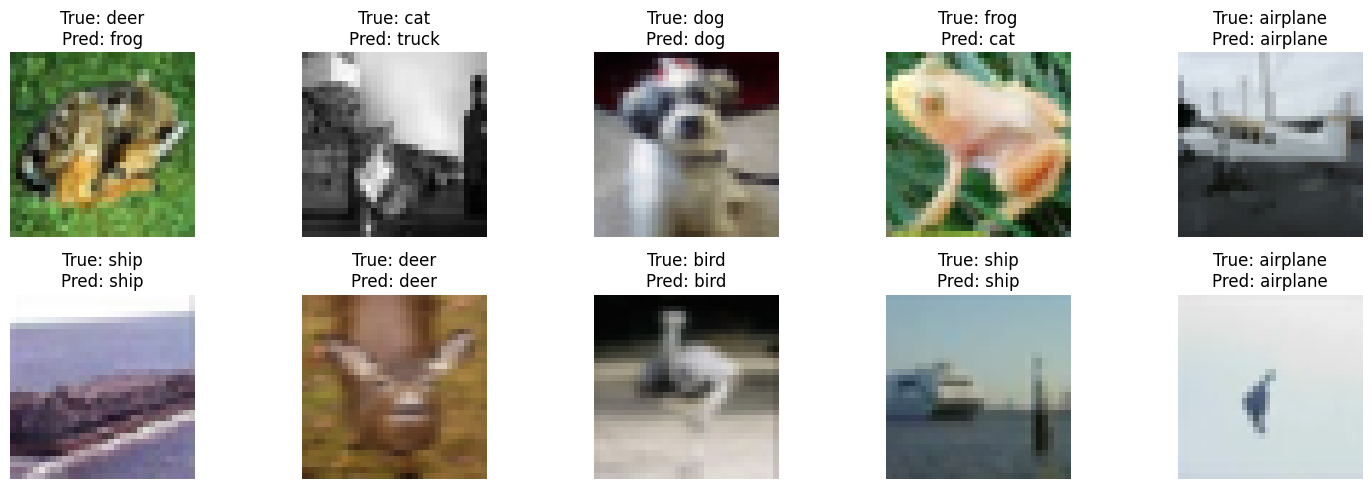

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"\nTest accuracy: {test_acc:.4f}")

# Get predictions from the model
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to class labels
true_labels = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class labels

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Function to plot images with true and predicted labels
def plot_images(images, true_labels, predicted_labels, class_names, num_images=10):
    # Randomly select indices from the test set
    random_indices = np.random.choice(len(images), num_images, replace=False)

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(random_indices):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[idx])
        plt.title(f"True: {class_names[true_labels[idx]]}\nPred: {class_names[predicted_labels[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot some test images with true and predicted labels
plot_images(x_test, true_labels, predicted_labels, class_names, num_images=10)